In [1]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

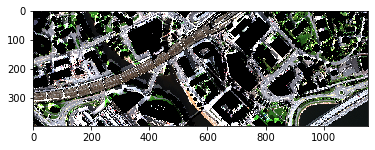

In [2]:
image = envi.open('../../hyperImage/stacked/ref/09_training_masked.hdr', '../../hyperImage/stacked/ref/09_training_masked.')
img = image.load()
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)))

In [67]:
img.shape

(397, 1153, 474)

In [ ]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(image)
img_pc.shape

In [ ]:
#NDVI calculation of the image 
vi = ndvi(image, 76, 105)
data_ndvi = np.nan_to_num(vi)

In [ ]:
## Combine PCA,and ndvi DATA
pc_img = img_pc.load()
df_pca = pd.DataFrame(pc_img.reshape(-1, img_pc.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, img_pc.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)

In [ ]:
main_df.to_csv('../../hyperImage/csv/features/Stacked_HSI_feature2', index=False)



In [3]:
main_df = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature2')

<function matplotlib.pyplot.show(*args, **kw)>

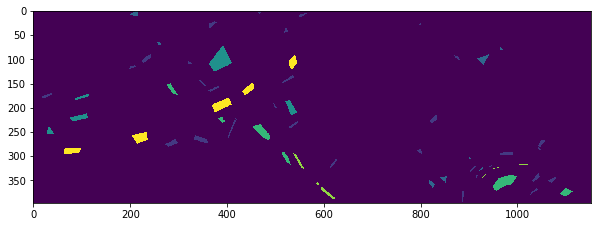

In [15]:
## Class image
gt_data = Image.open('../../hyperImage/stacked/ref/classref.tif')
gt = np.array(gt_data)
plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.show

In [16]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [17]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

# Using only hyperspectral data 

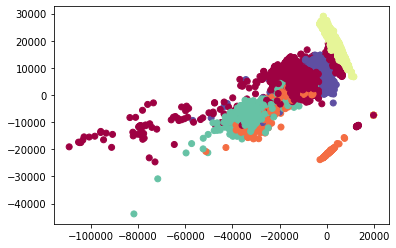

In [18]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0). all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

In [19]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [21]:
random_forest = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=2, n_jobs= -1)
random_forest.fit(X_train, y_train)
pred = random_forest.predict(X_test)
accuracy_score(y_test, pred)

0.9810333551340745

In [22]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=2, n_jobs= -1)
random_forest2.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [23]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [24]:
y_pred = random_forest2.predict(X_data_scaled)

In [25]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

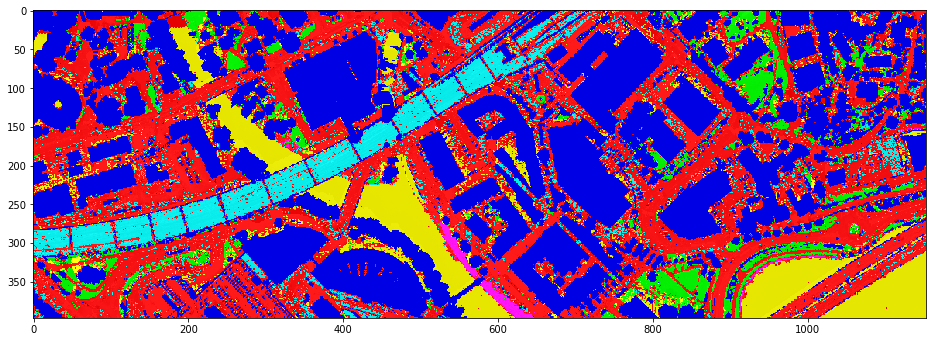

In [26]:
#full_image = envi.open('../hyperImage/09_full_image.hdr', '../hyperImage/09_full_image.')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.9
view.show_data

In [27]:
road = (predicted_hsi_mask == 1).astype(int)

In [28]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
from skimage import io
from skimage import img_as_uint
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)



/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

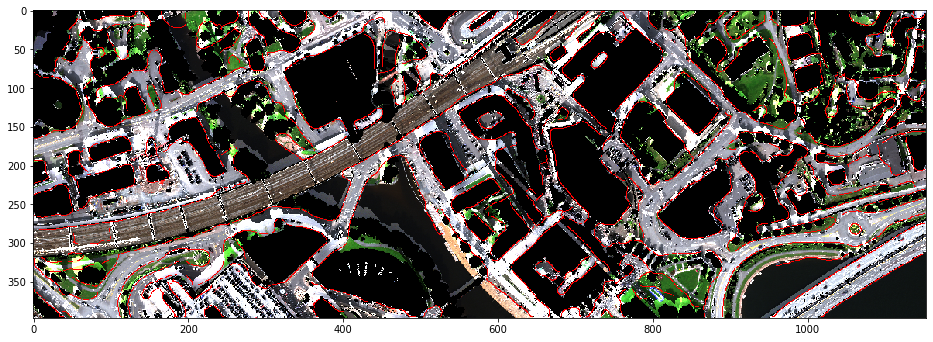

In [29]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [30]:
val_image = envi.open('../../hyperImage/stacked/ref/validation/08_vali_masked.hdr', '../../hyperImage/stacked/ref/validation/08_vali_masked.')
val_img = image.load()
val_img.shape

(397, 1153, 474)

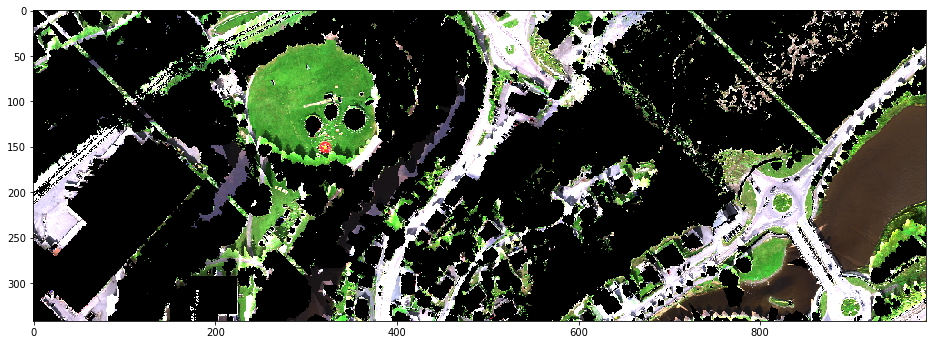

In [31]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [99]:
#compute PCA on the image 
pc = principal_components(val_image)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_image)
val_img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(342, 983, 75)

In [101]:
pc_img = val_img_pc.load()
pc_img = pc_img[:,:, :71]
pc_img.shape

(342, 983, 71)

In [102]:
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
main_df_val = pd.concat([df_pca], axis=1, sort=False)

In [103]:
main_df_val.to_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1', index=False)

In [32]:
main_df_val = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1')

In [33]:
main_df_val

PC1          PC2          PC3          PC4          PC5  \
0       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
1       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
2       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
3       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
4       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
...              ...          ...          ...          ...          ...   
336181 -10955.795116  6039.595995  4891.547657 -2445.342462  7582.960443   
336182  -9836.259876  5022.531363  4769.039880 -3206.856126  6536.374603   
336183  -6387.020876  6970.377627  7963.717546 -3436.109274  8568.657306   
336184  -7049.361874  7138.640258  8891.728496 -3161.313079  8388.955776   
336185  -5686.221977  7929.461775  6222.503968  -238.785506  9252.084067   

                PC6          PC7          PC8          PC9         PC10  ...  \
0        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
1        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
2        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
3        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
4        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
...             ...          ...          ...          ...          ...  ...   
336181 -1434.890131  -476.454318  2015.559349  1909.808587  2430.330381  ...   
336182 -1720.812448   324.660772   930.568527   759.102566   428.407515  ...   
336183 -3734.720215  3259.079433 -2127.672207  -546.795593 -1668.729675  ...   
336184 -3770.933546  1610.705315   -51.314330   249.440996  -492.486463  ...   
336185 -4239.440748  1585.286747   -55.574292   239.388870  -469.566215  ...   

               PC62        PC63        PC64        PC65       PC66       PC67  \
0         -3.287200   -1.998465    0.971086   -0.422678  -0.049231  -0.249895   
1         -3.287200   -1.998465    0.971086   -0.422678  -0.049231  -0.249895   
2         -3.287200   -1.998465    0.971086   -0.422678  -0.049231  -0.249895   
3         -3.287200   -1.998465    0.971086   -0.422678  -0.049231  -0.249895   
4         -3.287200   -1.998465    0.971086   -0.422678  -0.049231  -0.249895   
...             ...         ...         ...         ...        ...        ...   
336181   933.696980  546.599195 -305.362058  177.089701  -9.817050  41.928247   
336182  1031.252843  608.513303 -348.525265  189.734840 -17.334349  40.927541   
336183  -122.917550  -50.002655   43.431308    8.247761  14.548043  -0.628511   
336184   236.536905  139.441563  -59.327225   45.198406   7.209419  22.115634   
336185   240.278462  141.858892  -59.190595   47.485797   7.716836  26.419681   

             PC68       PC69       PC70       PC71  
0        0.229616  -0.125105   0.078513   0.063086  
1        0.229616  -0.125105   0.078513   0.063086  
2        0.229616  -0.125105   0.078513   0.063086  
3        0.229616  -0.125105   0.078513   0.063086  
4        0.229616  -0.125105   0.078513   0.063086  
...           ...        ...        ...        ...  
336181 -35.437209   5.703321 -27.045144  10.401062  
336182 -21.141926  16.544124 -36.275199   9.149798  
336183   8.716740  11.311020 -24.581857   1.274968  
336184   7.394622   8.388109  -7.954778   1.574247  
336185   7.958231  11.493580 -15.978809  -1.858148  

[336186 rows x 71 columns]

In [34]:
#NDVI calculation of the image 
vi = ndvi(val_image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [35]:
df_ndvi_val = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi_val.columns = [string]
#Concatenate 3 dataframe 
main_df_val = pd.concat([main_df_val, df_ndvi_val], axis=1, sort=False)

In [36]:
main_df_val_scaled = scaler.transform(main_df_val)
hsi_val_pred = random_forest.predict(main_df_val_scaled)
predicted_hsi_mask_val = hsi_val_pred.reshape(342, 983)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

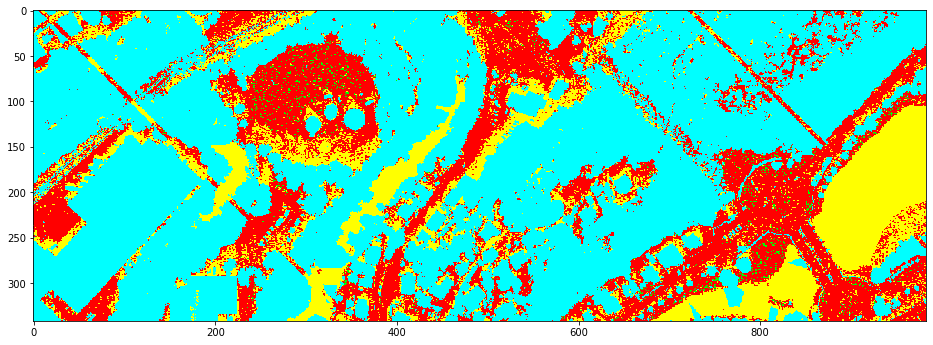

In [37]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [38]:
## Class image
gt_data_val = Image.open('../../hyperImage/stacked/ref/validation/val_class.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(342, 983)

In [39]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(336186, 1)

In [40]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [41]:
df_hsi_val

PC1          PC2          PC3          PC4          PC5  \
0       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
1       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
2       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
3       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
4       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
...              ...          ...          ...          ...          ...   
336181 -10955.795116  6039.595995  4891.547657 -2445.342462  7582.960443   
336182  -9836.259876  5022.531363  4769.039880 -3206.856126  6536.374603   
336183  -6387.020876  6970.377627  7963.717546 -3436.109274  8568.657306   
336184  -7049.361874  7138.640258  8891.728496 -3161.313079  8388.955776   
336185  -5686.221977  7929.461775  6222.503968  -238.785506  9252.084067   

                PC6          PC7          PC8          PC9         PC10  ...  \
0        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
1        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
2        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
3        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
4        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
...             ...          ...          ...          ...          ...  ...   
336181 -1434.890131  -476.454318  2015.559349  1909.808587  2430.330381  ...   
336182 -1720.812448   324.660772   930.568527   759.102566   428.407515  ...   
336183 -3734.720215  3259.079433 -2127.672207  -546.795593 -1668.729675  ...   
336184 -3770.933546  1610.705315   -51.314330   249.440996  -492.486463  ...   
336185 -4239.440748  1585.286747   -55.574292   239.388870  -469.566215  ...   

              PC64        PC65       PC66       PC67       PC68       PC69  \
0         0.971086   -0.422678  -0.049231  -0.249895   0.229616  -0.125105   
1         0.971086   -0.422678  -0.049231  -0.249895   0.229616  -0.125105   
2         0.971086   -0.422678  -0.049231  -0.249895   0.229616  -0.125105   
3         0.971086   -0.422678  -0.049231  -0.249895   0.229616  -0.125105   
4         0.971086   -0.422678  -0.049231  -0.249895   0.229616  -0.125105   
...            ...         ...        ...        ...        ...        ...   
336181 -305.362058  177.089701  -9.817050  41.928247 -35.437209   5.703321   
336182 -348.525265  189.734840 -17.334349  40.927541 -21.141926  16.544124   
336183   43.431308    8.247761  14.548043  -0.628511   8.716740  11.311020   
336184  -59.327225   45.198406   7.209419  22.115634   7.394622   8.388109   
336185  -59.190595   47.485797   7.716836  26.419681   7.958231  11.493580   

             PC70       PC71      NDVI  Target  
0        0.078513   0.063086  0.000000       0  
1        0.078513   0.063086  0.000000       0  
2        0.078513   0.063086  0.000000       0  
3        0.078513   0.063086  0.000000       0  
4        0.078513   0.063086  0.000000       0  
...           ...        ...       ...     ...  
336181 -27.045144  10.401062 -0.007535       0  
336182 -36.275199   9.149798  0.008403       0  
336183 -24.581857   1.274968 -0.007376       0  
336184  -7.954778   1.574247 -0.011854       0  
336185 -15.978809  -1.858148 -0.005634       0  

[336186 rows x 73 columns]

In [42]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values

In [43]:
X_data_scaled_val = scaler.transform(X_val)
y_pred = random_forest.predict(X_data_scaled_val)

In [44]:
accuracy_score(y_val, y_pred)

0.3774927239409292

In [45]:
target_names = ['Road', 'Vegetation', 'Soil','Unclassified', 'Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.49      0.94      0.64      3456
  Vegetation       0.98      0.06      0.12      5566
        Soil       0.00      0.00      0.00      4439
Unclassified       0.87      0.83      0.85      4135
       Water       0.00      0.00      0.00       940
 Train Track       0.00      0.00      0.00        18

    accuracy                           0.38     18554
   macro avg       0.39      0.30      0.27     18554
weighted avg       0.58      0.38      0.34     18554



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
cohen_kappa_score(y_val, y_pred)

0.29248055392631045

In [47]:
confusion_matrix(y_val, y_pred)

array([[3243,    0,    0,  198,    0,   15],
       [3111,  342,    0,  146,    0, 1967],
       [   1,    0,    0,   26,    0, 4412],
       [   7,    0,    0, 3419,    0,  709],
       [ 297,    6,    0,  130,    0,  507],
       [   5,    0,    0,   13,    0,    0]])

# Using Lidar Data Only

In [48]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/stacked/ref/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/stacked/ref/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [49]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar.to_csv('../../hyperImage/csv/features/Stacked_lidar_features', index=False)

In [50]:
df_lidar = pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features')

In [51]:
df_lidar

Lidar Intensity  Lidar nDSM  Target
0                  27.0   25.160000       0
1                   6.0   23.369999       0
2                   7.0   23.279999       0
3                  15.0   24.029999       0
4                   1.0   21.400000       0
...                 ...         ...     ...
457736             12.0    0.050000       0
457737              6.0    0.020000       0
457738             13.0    0.020000       0
457739              9.0    0.060000       0
457740              7.0    0.040000       0

[457741 rows x 3 columns]

In [52]:
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0). all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [53]:
scaler1 = StandardScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [55]:
random_forest2 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest2.fit(X_train, y_train)
pred = random_forest2.predict(X_test)
accuracy_score(y_test, pred)

0.7266187050359713

In [56]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [57]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = random_forest3.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

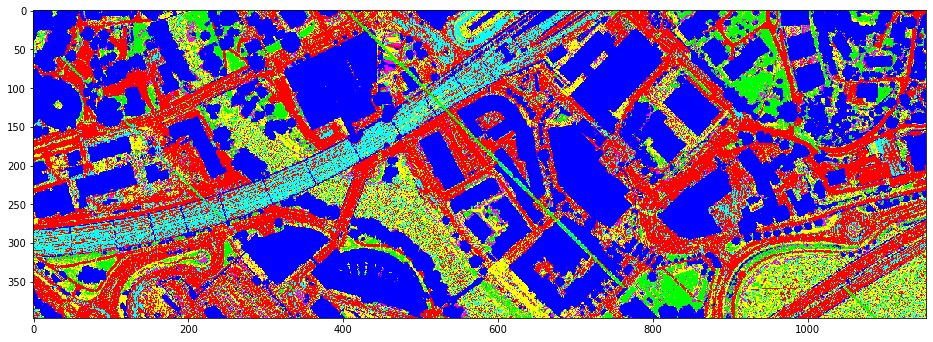

In [58]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [59]:
road = (predicted_lidar_mask == 1).astype(int)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

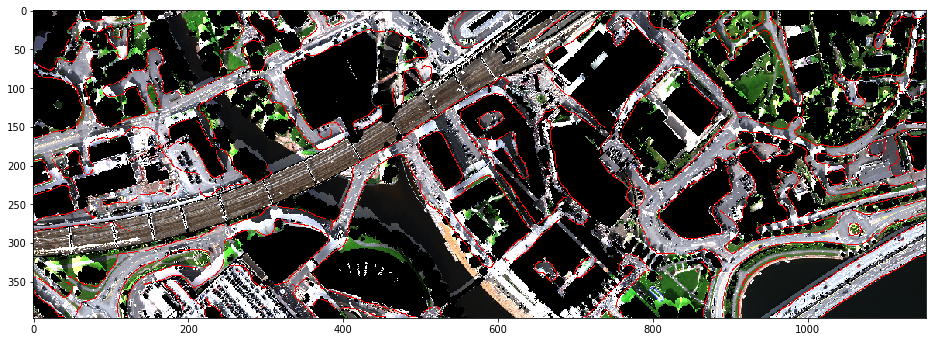

In [61]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

## Validation

In [145]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/stacked/ref/validation/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/stacked/ref/validation/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [147]:
l_intensity.shape

(342, 983)

In [139]:
df_lidar_val = pd.concat([df_intensity, df_dsm], axis=1, sort=False)
df_lidar_val.to_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1', index=False)

In [140]:
df_lidar_val = pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1')

In [141]:
df_lidar_val

Lidar Intensity  Lidar nDSM
0                  16.0   29.960000
1                  15.0   29.940000
2                  16.0   29.940000
3                  19.0   29.910000
4                  17.0   29.920000
...                 ...         ...
336181             23.0    0.009999
336182             25.0    0.010000
336183             23.0    0.090000
336184             19.0    0.040001
336185             25.0    0.030001

[336186 rows x 2 columns]

In [142]:
X_data_val_scaled = scaler1.transform(df_lidar_val.values)
y_pred = random_forest3.predict(X_data_val_scaled)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

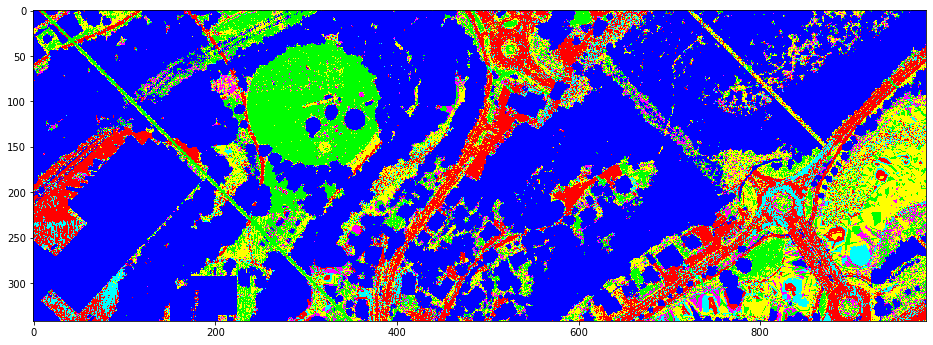

In [143]:
predicted_lidar_mask = y_pred.reshape(342, 983)
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [148]:
df_lidar_val = pd.concat([df_lidar_val, df_class_val], axis=1, sort=False)

In [149]:
df_lidar_val_masked = df_lidar_val[(df_lidar_val[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [150]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = random_forest3.predict(X_data_scaled_val)

In [151]:
accuracy_score(y_val, y_pred)

0.647084186698286

In [153]:
target_names = ['Road', 'Vegetation', 'Water','Unclassified', 'Soil', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.82      0.77      0.80      3456
  Vegetation       0.82      0.57      0.67      5566
       Water       0.59      0.99      0.74      4439
Unclassified       0.69      0.41      0.52      4135
        Soil       0.20      0.08      0.11       940
 Train Track       0.00      0.06      0.00        18

    accuracy                           0.65     18554
   macro avg       0.52      0.48      0.47     18554
weighted avg       0.70      0.65      0.65     18554



In [154]:
confusion_matrix(y_val, y_pred)

array([[2667,   28,    6,  179,   13,  563],
       [  34, 3154, 1952,  323,   80,   23],
       [  25,    0, 4400,    4,    2,    8],
       [ 454,  597,  650, 1711,  202,  521],
       [  53,   63,  461,  263,   73,   27],
       [  11,    1,    0,    5,    0,    1]])

In [155]:
cohen_kappa_score(y_val, y_pred)

0.546420605079155

# Using fused hyperspectral and lidar data 

In [156]:
#merge with HSI dataframe and lidar dataframe

In [157]:
df_lid_hsi = pd.concat([main_df, df_lidar], axis=1, sort=False)

In [158]:
df_lid_hsi

PC1           PC2          PC3         PC4           PC5  \
0       19835.212752  -7436.564557 -1792.510832   -8.205872    629.721888   
1       19835.212752  -7436.564557 -1792.510832   -8.205872    629.721888   
2       19835.212752  -7436.564557 -1792.510832   -8.205872    629.721888   
3       19835.212752  -7436.564557 -1792.510832   -8.205872    629.721888   
4       19835.212752  -7436.564557 -1792.510832   -8.205872    629.721888   
...              ...           ...          ...         ...           ...   
457736   2134.249350  21795.972947 -4727.130454  737.098558  14276.490260   
457737   2157.907766  21755.151082 -4741.608372  736.366754  14287.096224   
457738   2965.086187  20075.205704 -3906.868629  405.170589  11795.032674   
457739   2968.757528  20047.463885 -3902.819603  430.628191  11796.192496   
457740   6247.468046  14826.147058 -3532.297439  569.819352  10935.063028   

                PC6          PC7          PC8          PC9         PC10  ...  \
0       -287.834992   -25.252261   -68.652420   121.965378    33.196618  ...   
1       -287.834992   -25.252261   -68.652420   121.965378    33.196618  ...   
2       -287.834992   -25.252261   -68.652420   121.965378    33.196618  ...   
3       -287.834992   -25.252261   -68.652420   121.965378    33.196618  ...   
4       -287.834992   -25.252261   -68.652420   121.965378    33.196618  ...   
...             ...          ...          ...          ...          ...  ...   
457736  9461.400384  6534.948114  1389.534619  4429.734670  4058.501243  ...   
457737  9486.182908  6559.106074  1424.028961  4379.679185  4038.389307  ...   
457738  7824.489059  4315.798276 -4155.600073 -3904.993832   655.779275  ...   
457739  7839.375551  4337.282018 -4140.096701 -3927.037330   648.411634  ...   
457740  4877.793958  4075.939427   549.985979 -1713.812027 -6232.319648  ...   

               PC66        PC67         PC68        PC69        PC70  \
0         -0.260596   -0.165326     0.143836    0.160995    0.215499   
1         -0.260596   -0.165326     0.143836    0.160995    0.215499   
2         -0.260596   -0.165326     0.143836    0.160995    0.215499   
3         -0.260596   -0.165326     0.143836    0.160995    0.215499   
4         -0.260596   -0.165326     0.143836    0.160995    0.215499   
...             ...         ...          ...         ...         ...   
457736   612.068817 -828.125988  -354.241247 -343.109893  741.210935   
457737   611.917969 -828.496755  -354.255453 -343.139914  741.033019   
457738  1379.534595 -319.253390 -1108.250986  411.000436  784.293492   
457739  1380.055662 -318.587501 -1108.695092  409.318012  779.464174   
457740 -2182.771482  709.563018  1096.064662  484.370615  556.545109   

              PC71      NDVI  Lidar Intensity  Lidar nDSM  Target  
0        -0.949303  0.000000             27.0   25.160000       0  
1        -0.949303  0.000000              6.0   23.369999       0  
2        -0.949303  0.000000              7.0   23.279999       0  
3        -0.949303  0.000000             15.0   24.029999       0  
4        -0.949303  0.000000              1.0   21.400000       0  
...            ...       ...              ...         ...     ...  
457736  117.060364 -0.248120             12.0    0.050000       0  
457737  116.701908 -0.248120              6.0    0.020000       0  
457738 -535.954451 -0.246377             13.0    0.020000       0  
457739 -517.841456 -0.234899              9.0    0.060000       0  
457740 -576.846508 -0.219858              7.0    0.040000       0  

[457741 rows x 75 columns]

In [159]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0). all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [160]:
scaler3 = StandardScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_train, y_train)
pred = random_forest3.predict(X_test)
accuracy_score(y_test, pred)

0.9885546108567691

In [162]:
random_forest3 = RandomForestClassifier(n_estimators=100,bootstrap=True,max_depth = 110, min_samples_leaf= 3,
                                       min_samples_split=8, max_features=0.25, n_jobs= -1)
random_forest3.fit(X_scaled, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=110, max_features=0.25,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [163]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [164]:
y_pred = random_forest3.predict(X_data_scaled)

In [165]:
predicted_hsi_lidar_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

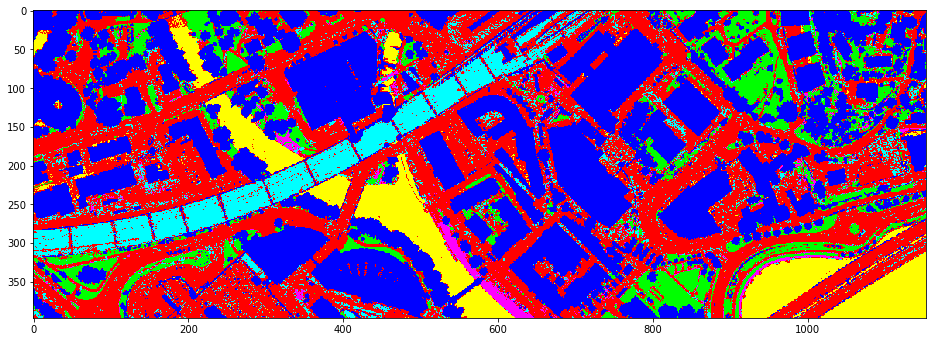

In [166]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [167]:
road = (predicted_hsi_lidar_mask == 1).astype(int)

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

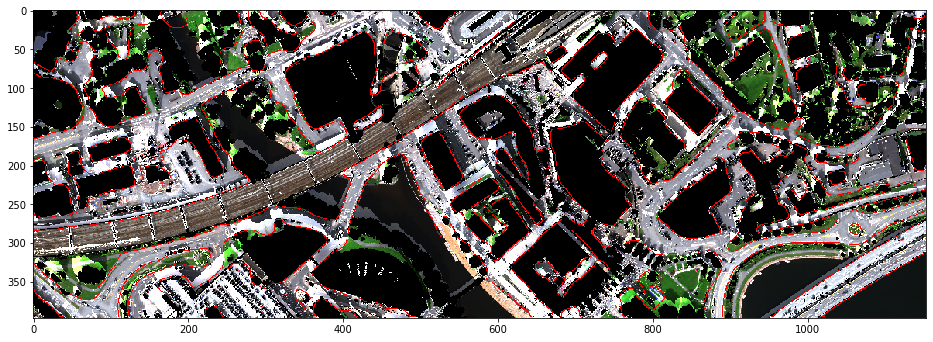

In [169]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation


In [170]:
main_df = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1')
point_cloud_val= pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1')
df_lid_hsi = pd.concat([main_df, df_ndvi_val, point_cloud_val], axis=1, sort=False)
df_lid_hsi

PC1          PC2          PC3          PC4          PC5  \
0       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
1       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
2       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
3       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
4       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
...              ...          ...          ...          ...          ...   
336181 -10955.795116  6039.595995  4891.547657 -2445.342462  7582.960443   
336182  -9836.259876  5022.531363  4769.039880 -3206.856126  6536.374603   
336183  -6387.020876  6970.377627  7963.717546 -3436.109274  8568.657306   
336184  -7049.361874  7138.640258  8891.728496 -3161.313079  8388.955776   
336185  -5686.221977  7929.461775  6222.503968  -238.785506  9252.084067   

                PC6          PC7          PC8          PC9         PC10  ...  \
0        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
1        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
2        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
3        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
4        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
...             ...          ...          ...          ...          ...  ...   
336181 -1434.890131  -476.454318  2015.559349  1909.808587  2430.330381  ...   
336182 -1720.812448   324.660772   930.568527   759.102566   428.407515  ...   
336183 -3734.720215  3259.079433 -2127.672207  -546.795593 -1668.729675  ...   
336184 -3770.933546  1610.705315   -51.314330   249.440996  -492.486463  ...   
336185 -4239.440748  1585.286747   -55.574292   239.388870  -469.566215  ...   

              PC65       PC66       PC67       PC68       PC69       PC70  \
0        -0.422678  -0.049231  -0.249895   0.229616  -0.125105   0.078513   
1        -0.422678  -0.049231  -0.249895   0.229616  -0.125105   0.078513   
2        -0.422678  -0.049231  -0.249895   0.229616  -0.125105   0.078513   
3        -0.422678  -0.049231  -0.249895   0.229616  -0.125105   0.078513   
4        -0.422678  -0.049231  -0.249895   0.229616  -0.125105   0.078513   
...            ...        ...        ...        ...        ...        ...   
336181  177.089701  -9.817050  41.928247 -35.437209   5.703321 -27.045144   
336182  189.734840 -17.334349  40.927541 -21.141926  16.544124 -36.275199   
336183    8.247761  14.548043  -0.628511   8.716740  11.311020 -24.581857   
336184   45.198406   7.209419  22.115634   7.394622   8.388109  -7.954778   
336185   47.485797   7.716836  26.419681   7.958231  11.493580 -15.978809   

             PC71      NDVI  Lidar Intensity  Lidar nDSM  
0        0.063086  0.000000             16.0   29.960000  
1        0.063086  0.000000             15.0   29.940000  
2        0.063086  0.000000             16.0   29.940000  
3        0.063086  0.000000             19.0   29.910000  
4        0.063086  0.000000             17.0   29.920000  
...           ...       ...              ...         ...  
336181  10.401062 -0.007535             23.0    0.009999  
336182   9.149798  0.008403             25.0    0.010000  
336183   1.274968 -0.007376             23.0    0.090000  
336184   1.574247 -0.011854             19.0    0.040001  
336185  -1.858148 -0.005634             25.0    0.030001  

[336186 rows x 74 columns]

In [171]:
X_data_scaled = scaler3.transform(df_lid_hsi)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

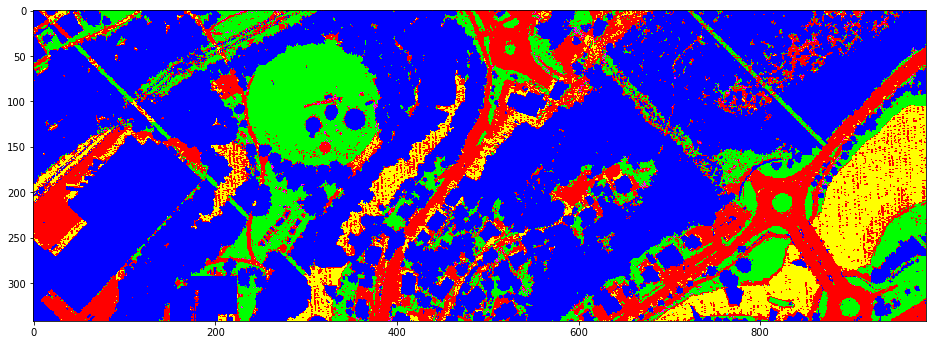

In [172]:
val_pred_full = random_forest3.predict(X_data_scaled)
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [174]:
df_val = pd.concat([df_lid_hsi, df_class_val], axis=1, sort=False)



In [175]:
df_val

PC1          PC2          PC3          PC4          PC5  \
0       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
1       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
2       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
3       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
4       17165.675664 -3972.038444 -2404.834289  -566.960602  -498.795311   
...              ...          ...          ...          ...          ...   
336181 -10955.795116  6039.595995  4891.547657 -2445.342462  7582.960443   
336182  -9836.259876  5022.531363  4769.039880 -3206.856126  6536.374603   
336183  -6387.020876  6970.377627  7963.717546 -3436.109274  8568.657306   
336184  -7049.361874  7138.640258  8891.728496 -3161.313079  8388.955776   
336185  -5686.221977  7929.461775  6222.503968  -238.785506  9252.084067   

                PC6          PC7          PC8          PC9         PC10  ...  \
0        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
1        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
2        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
3        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
4        176.499534  -129.140864    30.450233    34.952119    32.885730  ...   
...             ...          ...          ...          ...          ...  ...   
336181 -1434.890131  -476.454318  2015.559349  1909.808587  2430.330381  ...   
336182 -1720.812448   324.660772   930.568527   759.102566   428.407515  ...   
336183 -3734.720215  3259.079433 -2127.672207  -546.795593 -1668.729675  ...   
336184 -3770.933546  1610.705315   -51.314330   249.440996  -492.486463  ...   
336185 -4239.440748  1585.286747   -55.574292   239.388870  -469.566215  ...   

             PC66       PC67       PC68       PC69       PC70       PC71  \
0       -0.049231  -0.249895   0.229616  -0.125105   0.078513   0.063086   
1       -0.049231  -0.249895   0.229616  -0.125105   0.078513   0.063086   
2       -0.049231  -0.249895   0.229616  -0.125105   0.078513   0.063086   
3       -0.049231  -0.249895   0.229616  -0.125105   0.078513   0.063086   
4       -0.049231  -0.249895   0.229616  -0.125105   0.078513   0.063086   
...           ...        ...        ...        ...        ...        ...   
336181  -9.817050  41.928247 -35.437209   5.703321 -27.045144  10.401062   
336182 -17.334349  40.927541 -21.141926  16.544124 -36.275199   9.149798   
336183  14.548043  -0.628511   8.716740  11.311020 -24.581857   1.274968   
336184   7.209419  22.115634   7.394622   8.388109  -7.954778   1.574247   
336185   7.716836  26.419681   7.958231  11.493580 -15.978809  -1.858148   

            NDVI  Lidar Intensity  Lidar nDSM  Target  
0       0.000000             16.0   29.960000       0  
1       0.000000             15.0   29.940000       0  
2       0.000000             16.0   29.940000       0  
3       0.000000             19.0   29.910000       0  
4       0.000000             17.0   29.920000       0  
...          ...              ...         ...     ...  
336181 -0.007535             23.0    0.009999       0  
336182  0.008403             25.0    0.010000       0  
336183 -0.007376             23.0    0.090000       0  
336184 -0.011854             19.0    0.040001       0  
336185 -0.005634             25.0    0.030001       0  

[336186 rows x 75 columns]

In [176]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values

In [177]:
X_data_scaled_val = scaler3.transform(X_val)
val_pred_full_ = random_forest3.predict(X_data_scaled_val)

In [178]:
accuracy_score(y_val, val_pred_full_)

0.7699148431605045

In [180]:
target_names = ['Road', 'Vegetation','Water', 'Unclassified', 'Soil', 'Train Track']
print(classification_report(y_val, val_pred_full_, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.77      0.99      0.86      3456
  Vegetation       0.98      0.64      0.77      5566
       Water       0.59      0.99      0.74      4439
Unclassified       0.96      0.70      0.81      4135
        Soil       0.92      0.02      0.05       940
 Train Track       0.00      0.00      0.00        18

    accuracy                           0.77     18554
   macro avg       0.70      0.56      0.54     18554
weighted avg       0.84      0.77      0.75     18554



In [181]:
cohen_kappa_score(y_val, val_pred_full_)

0.6990233272747265

In [182]:
confusion_matrix(y_val, val_pred_full_)

array([[3419,    6,    5,   25,    1,    0],
       [  48, 3563, 1949,    4,    1,    1],
       [  45,    0, 4391,    3,    0,    0],
       [ 601,    0,  645, 2889,    0,    0],
       [ 327,   74,  437,   78,   23,    1],
       [  11,    2,    0,    5,    0,    0]])